In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import zipfile
import re
import sys

import xgboost as xgb
import time

from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [4]:
path = "..."

In [5]:
zf_train_1 = zipfile.ZipFile(path + 'train_1.csv.zip')
zf_train_2 = zipfile.ZipFile(path + 'train_2.csv.zip')
zf_key_1 = zipfile.ZipFile(path + 'key_1.csv.zip')
zf_key_2 = zipfile.ZipFile(path + 'key_2.csv.zip')
zf_sb_1 = zipfile.ZipFile(path + 'sample_submission_1.csv.zip')
zf_sb_2 = zipfile.ZipFile(path + 'sample_submission_2.csv.zip')

#train_1 = pd.read_csv(zf_train_1.open('train_1.csv'))
train_2 = pd.read_csv(zf_train_2.open('train_2.csv'))
#key_1 = pd.read_csv(zf_key_1.open('key_1.csv'))
#key_2 = pd.read_csv(zf_key_2.open('key_2.csv'))
#sample_sub_1 = pd.read_csv(zf_sb_1.open('sample_submission_1.csv'))
#sample_sub_2 = pd.read_csv(zf_sb_2.open('sample_submission_2.csv'))

In [6]:
'''sample_sub_2 = sample_sub_2[:100]
sample_sub_2.info(verbose = False, memory_usage = 'deep')'''

"sample_sub_2 = sample_sub_2[:100]\nsample_sub_2.info(verbose = False, memory_usage = 'deep')"

In [7]:
print(train_2.shape)
train_2.head()

(145063, 804)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [8]:
def split_func(page,k):
    p_s = page.split("_")
    l = len(p_s)
    if k != 0:
        return p_s[l-k]
    else:
        return ' '.join(p_s[:l-2])

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

In [9]:
'''key_2['date'] = key_2.Page.apply(lambda x: x[-10:])
key_2['Page'] = key_2.Page.apply(lambda x: x[:(len(x)-11)])
date_list= key_2.date.unique().tolist() + train_2.columns[1:].to_list()'''

"key_2['date'] = key_2.Page.apply(lambda x: x[-10:])\nkey_2['Page'] = key_2.Page.apply(lambda x: x[:(len(x)-11)])\ndate_list= key_2.date.unique().tolist() + train_2.columns[1:].to_list()"

In [10]:
date_list = train_2.columns[1:].to_list()
date_map =pd.DataFrame(date_list)
date_map.columns = ['date']
date_map['date'] = pd.to_datetime(date_map['date'])
date_map = date_map.sort_values('date').reset_index()
date_map['date_id'] = date_map.index
date_map.drop('index', axis = 1,  inplace = True)
date_map['month'] = date_map['date'].apply(lambda x: x.month)
date_map['year'] = date_map['date'].apply(lambda x: x.year)
date_map['day'] = date_map['date'].apply(lambda x: x.day)
date_map['weekday'] = date_map['date'].apply(lambda x: x.weekday())
date_map['weeknum'] = date_map['date'].apply(lambda x: x.isocalendar()[1])
date_map['month'] = date_map['month'].astype(np.int8)
date_map['year'] = date_map['year'].astype(np.int16)
date_map['day'] = date_map['day'].astype(np.int8)
date_map['date_id'] = date_map['date_id'].astype(np.int16)

date_map.head()

,date,date_id,month,year,day,weekday,weeknum
0,2015-07-01,0,7,2015,1,2,27
1,2015-07-02,1,7,2015,2,3,27
2,2015-07-03,2,7,2015,3,4,27
3,2015-07-04,3,7,2015,4,5,27
4,2015-07-05,4,7,2015,5,6,27


In [11]:
page_map = pd.DataFrame(train_2.Page.unique())
page_map['page_id'] = page_map.index
page_map.columns = ['Page','page_id']
page_map['agent']= page_map['Page'].apply(lambda x: split_func(x,1))
page_map['access']= page_map['Page'].apply(lambda x: split_func(x,2))
page_map['project']= page_map['Page'].apply(lambda x: split_func(x,0))
page_map['lang']= page_map['Page'].apply(lambda x: get_language(x))
page_map['agent_code'] = LabelEncoder().fit_transform(page_map.agent)
page_map['access_code'] = LabelEncoder().fit_transform(page_map.access)
page_map['lang_code'] = LabelEncoder().fit_transform(page_map.lang)
page_map['agent_code'] = page_map.agent_code.astype(np.int8)
page_map['access_code'] = page_map.access_code.astype(np.int8)
page_map['lang_code'] = page_map.lang_code.astype(np.int8)

#key_2 = pd.merge( key_2, page_map, on = 'Page', how = 'left')
#key_2.drop('Page', axis = 1, inplace = True)
page_map.head()

,Page,page_id,agent,access,project,lang,agent_code,access_code,lang_code
0,2NE1_zh.wikipedia.org_all-access_spider,0,spider,all-access,2NE1 zh.wikipedia.org,zh,1,0,7
1,2PM_zh.wikipedia.org_all-access_spider,1,spider,all-access,2PM zh.wikipedia.org,zh,1,0,7
2,3C_zh.wikipedia.org_all-access_spider,2,spider,all-access,3C zh.wikipedia.org,zh,1,0,7
3,4minute_zh.wikipedia.org_all-access_spider,3,spider,all-access,4minute zh.wikipedia.org,zh,1,0,7
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,4,spider,all-access,52 Hz I Love You zh.wikipedia.org,zh,1,0,7


In [12]:
train_2 = pd.merge(train_2, page_map[['Page','page_id']], on = 'Page', how = 'left')
train_2.drop('Page',axis = 1, inplace = True)

train_2 = train_2[train_2.page_id < 300] #filtering for efficient proecessing

train_2 = pd.melt(train_2, 
    id_vars =['page_id'],
        value_vars = train_2.columns[:-1],
           var_name = 'date',
             value_name = 'visits')

train_2['date'] = pd.to_datetime(train_2.date)
train_2 = pd.merge(train_2, date_map, on  = 'date', how = 'left')
train_2.drop('date', axis = 1, inplace = True)
train_2['date_id'] = train_2.date_id.astype(np.int16)
train_2 = pd.merge(train_2, page_map[['page_id','agent_code','access_code','lang_code']], on = 'page_id', how = 'left')
print(train_2.date_id.isnull().sum())
print(train_2.info(verbose=False, memory_usage="deep"))
train_2.head()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240900 entries, 0 to 240899
Columns: 11 entries, page_id to lang_code
dtypes: float64(1), int16(2), int64(3), int8(5)
memory usage: 11.3 MB
None


,page_id,visits,date_id,month,year,day,weekday,weeknum,agent_code,access_code,lang_code
0,0,18.0,0,7,2015,1,2,27,1,0,7
1,1,11.0,0,7,2015,1,2,27,1,0,7
2,2,1.0,0,7,2015,1,2,27,1,0,7
3,3,35.0,0,7,2015,1,2,27,1,0,7
4,4,NaN,0,7,2015,1,2,27,1,0,7


In [13]:
#key_2.info(verbose=False, memory_usage="deep")

'''key_2 = key_2.sort_values(['page_id','date_id','day'])
key = key_2[['Id','page_id','date_id']]
key_2.drop('Id', axis = 1, inplace = True)'''

"key_2 = key_2.sort_values(['page_id','date_id','day'])\nkey = key_2[['Id','page_id','date_id']]\nkey_2.drop('Id', axis = 1, inplace = True)"

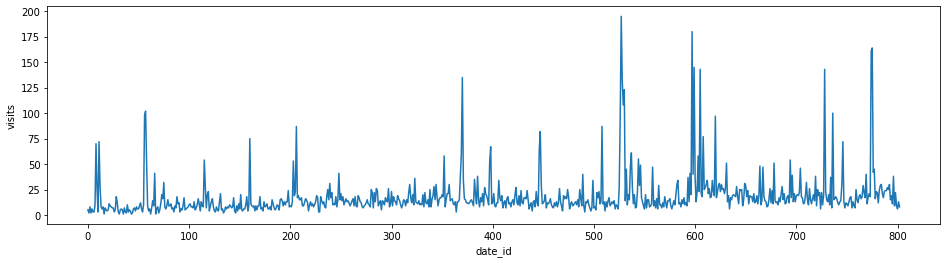

In [14]:
p_id = 115
plt.figure(figsize = (16,4))
sn.lineplot('date_id', 'visits', data = train_2[train_2.page_id == p_id])

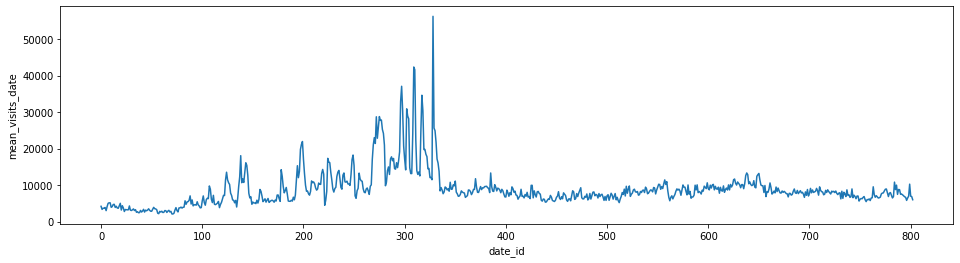

In [15]:
group = train_2.groupby(['date_id']).agg({'visits':'sum'})
group.columns = ['mean_visits_date']
group.reset_index (inplace = True)

plt.figure(figsize = (16,4))
sn.lineplot('date_id', 'mean_visits_date', data = group)

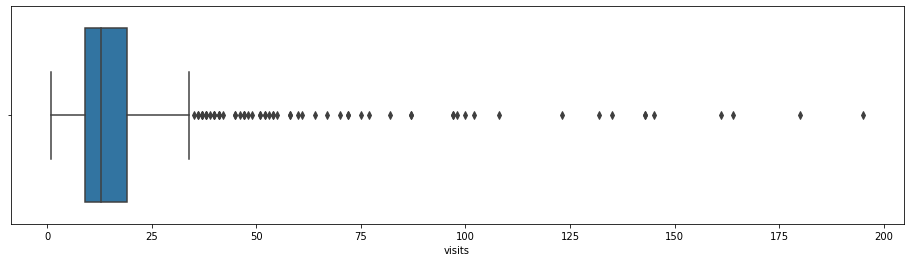

In [16]:
p_id = 115
plt.figure(figsize = (16,4))
sn.boxplot('visits', data = train_2[train_2.page_id == p_id])

In [17]:
#test set

'''key_2['date'] = pd.to_datetime(key_2['date'])
key_2 = pd.merge(key_2, date_map, on = 'date', how = 'left')
key_2.drop('date', axis = 1, inplace = True)
key_2 = pd.merge(key_2, page_map, on = 'Page', how = 'left')
key_2.drop(['Page','agent','access','project','lang'], axis =1, inplace = True)'''

"key_2['date'] = pd.to_datetime(key_2['date'])\nkey_2 = pd.merge(key_2, date_map, on = 'date', how = 'left')\nkey_2.drop('date', axis = 1, inplace = True)\nkey_2 = pd.merge(key_2, page_map, on = 'Page', how = 'left')\nkey_2.drop(['Page','agent','access','project','lang'], axis =1, inplace = True)"

## Missing values 

In [18]:
'''group = train_2.groupby(['page_id'])['visits'].agg({'visits': 'mean'})
group.columns = ['mean_visits']
group.reset_index(inplace = True)
'''
#train_2['visits'] = train_2.groupby(['page_id']).transform(lambda x: x.fillna(x.mean()))
train_2['visits'] = train_2.groupby(['page_id']).transform(lambda x: x.fillna(x.median()))

#train_2.fillna(0, inplace = True)
train_2['visits'] = train_2.visits.astype(np.int32)
print(train_2.info(verbose=False, memory_usage="deep"))
print(train_2.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240900 entries, 0 to 240899
Columns: 11 entries, page_id to lang_code
dtypes: int16(2), int32(1), int64(3), int8(5)
memory usage: 10.3 MB
None
page_id        0
visits         0
date_id        0
month          0
year           0
day            0
weekday        0
weeknum        0
agent_code     0
access_code    0
lang_code      0
dtype: int64


In [19]:
group = train_2.groupby(['agent_code']).agg({'visits':'median'})
group.columns = ['median_visits_agent_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'agent_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'agent_code', how = 'left')
train_2['median_visits_agent_code'] = train_2.median_visits_agent_code.astype(np.float32)
#key_2['median_visits_agent_code'] = key_2.median_visits_agent_code.astype(np.float32)

In [20]:
group = train_2.groupby(['access_code']).agg({'visits':'median'})
group.columns = ['median_visits_access_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'access_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'access_code', how = 'left')
train_2['median_visits_access_code'] = train_2.median_visits_access_code.astype(np.float32)
#key_2['median_visits_access_code'] = key_2.median_visits_access_code.astype(np.float32)

In [21]:
group = train_2.groupby(['lang_code']).agg({'visits':'median'})
group.columns = ['median_visits_lang_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'lang_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'lang_code', how = 'left')
train_2['median_visits_lang_code'] = train_2.median_visits_lang_code.astype(np.float32)
#key_2['median_visits_lang_code'] = key_2.median_visits_lang_code.astype(np.float32)

In [22]:
group = train_2.groupby(['month']).agg({'visits':'mean'})
group.columns = ['mean_visits_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'month', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_month'] = train_2.mean_visits_month.astype(np.float32)
#key_2['mean_visits_month'] = key_2.mean_visits_month.astype(np.float32)

In [23]:
group = train_2.groupby(['month', 'lang_code']).agg({'visits':'mean'})
group.columns = ['mean_visits_month_lang']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['month', 'lang_code'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_month_lang'] = train_2.mean_visits_month_lang.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [24]:
group = train_2.groupby(['page_id']).agg({'visits':'mean'})
group.columns = ['mean_visits_page']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_page'] = train_2.mean_visits_page.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [25]:
group = train_2.groupby(['page_id','month']).agg({'visits':'mean'})
group.columns = ['mean_visits_page_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_page_month'] = train_2.mean_visits_page_month.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [26]:
group = train_2.groupby(['access_code','month']).agg({'visits':'mean'})
group.columns = ['mean_visits_access_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['access_code','month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_access_month'] = train_2.mean_visits_access_month.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [27]:
group = train_2.groupby(['agent_code','month']).agg({'visits':'mean'})
group.columns = ['mean_visits_agent_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['agent_code','month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_agent_month'] = train_2.mean_visits_agent_month.astype(np.float32)

In [28]:
group = train_2.groupby(['page_id','weekday']).agg({'visits':'mean'})
group.columns = ['mean_visits_page_week']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'weekday'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_page_week'] = train_2.mean_visits_page_week.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [29]:
group = train_2.groupby(['page_id','weeknum']).agg({'visits':'mean'})
group.columns = ['mean_visits_page_weeknum']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'weeknum'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['mean_visits_page_weeknum'] = train_2.mean_visits_page_weeknum.astype(np.float32)
#key_2['mean_visits_month_lang'] = key_2.mean_visits_month_lang.astype(np.float32)

In [30]:
group = train_2.groupby(['agent_code']).agg({'visits':'mean'})
group.columns = ['mean_visits_agent_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'agent_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'agent_code', how = 'left')
train_2['mean_visits_agent_code'] = train_2.mean_visits_agent_code.astype(np.float32)
#key_2['mean_visits_agent_code'] = key_2.mean_visits_agent_code.astype(np.float32)

In [31]:
group = train_2.groupby(['access_code']).agg({'visits':'mean'})
group.columns = ['mean_visits_access_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'access_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'access_code', how = 'left')
train_2['mean_visits_access_code'] = train_2.mean_visits_access_code.astype(np.float32)
#key_2['mean_visits_access_code'] = key_2.mean_visits_access_code.astype(np.float32)

In [32]:
group = train_2.groupby(['lang_code']).agg({'visits':'mean'})
group.columns = ['mean_visits_lang_code']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'lang_code', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'lang_code', how = 'left')
train_2['mean_visits_lang_code'] = train_2.mean_visits_lang_code.astype(np.float32)
#key_2['mean_visits_lang_code'] = key_2.mean_visits_lang_code.astype(np.float32)

In [33]:
group = train_2.groupby(['month']).agg({'visits':'median'})
group.columns = ['median_visits_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = 'month', how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_month'] = train_2.median_visits_month.astype(np.float32)
#key_2['median_visits_month'] = key_2.median_visits_month.astype(np.float32)

In [34]:
group = train_2.groupby(['month', 'lang_code']).agg({'visits':'median'})
group.columns = ['median_visits_month_lang']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['month', 'lang_code'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_month_lang'] = train_2.median_visits_month_lang.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [35]:
group = train_2.groupby(['page_id']).agg({'visits':'median'})
group.columns = ['median_visits_page']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_page'] = train_2.median_visits_page.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [36]:
group = train_2.groupby(['page_id','month']).agg({'visits':'median'})
group.columns = ['median_visits_page_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_page_month'] = train_2.median_visits_page_month.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [37]:
group = train_2.groupby(['access_code','month']).agg({'visits':'median'})
group.columns = ['median_visits_access_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['access_code','month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_access_month'] = train_2.median_visits_access_month.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [38]:
group = train_2.groupby(['agent_code','month']).agg({'visits':'median'})
group.columns = ['median_visits_agent_month']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['agent_code','month'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_agent_month'] = train_2.median_visits_agent_month.astype(np.float32)

In [39]:
group = train_2.groupby(['page_id','weekday']).agg({'visits':'median'})
group.columns = ['median_visits_page_week']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'weekday'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_page_week'] = train_2.median_visits_page_week.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [40]:
group = train_2.groupby(['page_id','weeknum']).agg({'visits':'median'})
group.columns = ['median_visits_page_weeknum']
group.reset_index (inplace = True)
train_2 = pd.merge(train_2, group, on = ['page_id', 'weeknum'], how = 'left')
#key_2 = pd.merge(key_2, group, on = 'month', how = 'left')
train_2['median_visits_page_weeknum'] = train_2.median_visits_page_weeknum.astype(np.float32)
#key_2['median_visits_month_lang'] = key_2.median_visits_month_lang.astype(np.float32)

In [41]:
year_dict = {2015: 0,
             2016: 1,
            2017: 2 }
train_2['year_num'] = train_2.year.map(year_dict)


In [42]:
x_train = train_2[(train_2.date_id <= 700)].drop(['visits'], axis = 1)
y_train = train_2[(train_2.date_id <= 700)]['visits']

x_valid = train_2[train_2.date_id > 700].drop(['visits'], axis = 1)
y_valid = train_2[train_2.date_id > 700]['visits']

In [ ]:
#from sklearn.model_selection import GridSearchCV

smape_list = []
#learning_rate = [0.1,0.2,0.3]
#subsample = [0.6,0.7,0.8]
#max_depth = [3,4,5,6,7]


xgb1 = XGBRegressor(
            max_depth=7,
            n_estimators=1000,
            min_child_weight=300, 
            colsample_bytree=0.8, 
            subsample=0.8, 
            eta=0.1,    
            seed=42
        )

xgb1.fit(x_train,y_train)

y_pred =  xgb1.predict(x_valid)
smape(y_valid, y_pred)
#smape_list.append([smape])
#smape

In [48]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(normalize = True, 
                     n_jobs = 100)
lm.fit(x_train, y_train)
y_pred = lm.predict(x_valid)
smape(y_valid, y_pred)

142.81167150213477

In [59]:
%%time

from lightgbm import LGBMRegressor

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
   'metric': ['auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 12,  
    "max_bin": 512,
    "num_iterations": 1000
}

lgbm = LGBMRegressor()

lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_valid)
smape(y_valid, y_pred)

Wall time: 2.12 s


47.627982315861146

In [68]:
from sklearn.linear_model import Ridge

for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    lm = Ridge(alpha = alpha)
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_valid)
    print(smape(y_valid, y_pred))

140.30136605373576
138.13005618599271
136.21894305599076
134.5775678520325
133.13600994721787
131.87330205740273
130.7614439390982
129.7689029945785
128.87155605280125


In [69]:
from sklearn.linear_model import Lasso

lm = Lasso(alpha = 0.1)
lm.fit(x_train, y_train)
y_pred = lm.predict(x_valid)
print(smape(y_valid, y_pred))

C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450127765.3050518, tolerance: 2504020.926071162
  positive)


113.05384472888603


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440649552.8207836, tolerance: 2504020.926071162
  positive)


112.78996061652396


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176797676.7308197, tolerance: 2504020.926071162
  positive)


112.52422654402521


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86666958.61997032, tolerance: 2504020.926071162
  positive)


112.25647665416922


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48582174.70100975, tolerance: 2504020.926071162
  positive)


111.98748046590329


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30275642.700206757, tolerance: 2504020.926071162
  positive)


111.78724215036746


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20374109.262599945, tolerance: 2504020.926071162
  positive)


111.6283740839982


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14553870.15840149, tolerance: 2504020.926071162
  positive)


111.46868801500828
111.30876722135108


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10917539.031703949, tolerance: 2504020.926071162
  positive)


In [75]:
from sklearn.linear_model import ElasticNet

lm = ElasticNet(alpha = 0.1)
lm.fit(x_train, y_train)
y_pred = lm.predict(x_valid)
print(smape(y_valid, y_pred))

113.1476212364091


C:\Users\apathak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2926225433.7548428, tolerance: 2504020.926071162
  positive)


In [81]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth = 10,
                            min_samples_split = 10,
                            min_samples_leaf = 100)
tree.fit(x_train, y_train)
y_pred = lm.predict(x_valid)
print(smape(y_valid, y_pred))

47.85789987484185
